In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import random

import os
import pandas as pd
from torchvision.io import read_image

from torch.utils import data
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor


from torch.utils.data import DataLoader, TensorDataset, random_split

import pickle

from torch.nn import Conv2d
from torch import optim

torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)


# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
sc = StandardScaler()


In [2]:
with open("Data/MoS2_Analysis_Processed_Data2", "rb") as fp:   # Unpickling
  MoS2_data = pickle.load(fp)

df = pd.DataFrame(MoS2_data)
T = df['T']

T_classes = {900.0: 0, 950.0: 1, 1000.0: 2}
#print(MoS2_activities_substrate2['T'])
T_target = [T_classes[T[index]] for index, item in enumerate(T)]
sampleId = df['sampleId']
sampleLabel = df['sampleLabel']
Time = df['time']
data_image = np.array([np.array(item) for item in df['image']])
print(df.keys())

Index(['sampleLabel', 'sampleId', 'image', 'T', 'time', 'substrate'], dtype='object')


In [3]:
Data_CNN = data_image
print(Data_CNN.shape)
Data_CNN_rgb = np.repeat(Data_CNN[..., np.newaxis], 3, -1)
print(Data_CNN_rgb.shape)
Data_CNN_rgb = Data_CNN_rgb.transpose(0, 3, 1, 2)/255
print(Data_CNN_rgb.shape)

(262, 224, 224)
(262, 224, 224, 3)
(262, 3, 224, 224)


In [5]:
transform_test = transforms.Compose([
      #transforms.ToPILImage(),
      transforms.ToTensor(),
      #transforms.Normalize(mean=mean, std=std),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [13]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pre-trained ResNet model

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

resnet.eval()
#resnet = resnet.double()  # Set the model to evaluation mode
#model = model.double()
# Choose a specific layer to extract features from

target_layer = resnet.avgpool  # can be layer1 - layer4

# Define a hook to capture the activations from the target layer

activations = []


def hook_fn(module, input, output):
    activations.append(output)

 

hook = target_layer.register_forward_hook(hook_fn)

# Load and preprocess an image

#image = Image.open(image_path)


for image in Data_CNN_rgb:
    #image = image.transpose(1, 2, 0)
    #input_tensor = transform_test(image)

    #input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch
    
    item_tensor = torch.tensor(image, dtype=torch.float32)
    input_batch = item_tensor.unsqueeze(0)  

# Pass the input through the model to trigger the hook and capture activations

    with torch.no_grad():

        _ = resnet(input_batch)

 
# Remove the hook to prevent memory leaks

hook.remove()
 

# The activations list now contains the convolutional activations from the target layer

# Each element corresponds to the activations of a single batch of input

print(activations[0].shape)

print(len(activations))
flattened_ImageNet = np.array([a.numpy() for a in activations]).reshape(len(activations),-1)
print(flattened_ImageNet.shape)

torch.Size([1, 512, 1, 1])
262
(262, 512)


In [14]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# Load pre-trained ResNet model

import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

model_micro = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
#url = pmm.util.get_pretrained_microscopynet_url('resnet50', 'microscopynet')
url = pmm.util.get_pretrained_microscopynet_url('resnet18', 'micronet')
map_location=torch.device('cpu')
model_micro.load_state_dict(model_zoo.load_url(url))

model_micro.eval()
#model_micro = model_micro.double()  # Set the model to evaluation mode
#model = model.double()
# Choose a specific layer to extract features from

target_layer = model_micro.avgpool  # can be layer1 - layer4

# Define a hook to capture the activations from the target layer

activations = []


def hook_fn(module, input, output):
    activations.append(output)

 

hook = target_layer.register_forward_hook(hook_fn)

# Load and preprocess an image

#image = Image.open(image_path)




for image in Data_CNN_rgb:
    #image = image.transpose(1, 2, 0)
    #input_tensor = transform_test(image)

    #input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch

    item_tensor = torch.tensor(image, dtype=torch.float32)
    input_batch = item_tensor.unsqueeze(0)     
# Pass the input through the model to trigger the hook and capture activations

    with torch.no_grad():

        _ = model_micro(input_batch)

 
# Remove the hook to prevent memory leaks

hook.remove()
 

# The activations list now contains the convolutional activations from the target layer

# Each element corresponds to the activations of a single batch of input

print(activations[0].shape)

print(len(activations))
flattened_MicroNet = np.array([a.numpy() for a in activations]).reshape(len(activations),-1)
print(flattened_MicroNet.shape)

Using cache found in /home/faculty/iam5249/.cache/torch/hub/pytorch_vision_v0.10.0


torch.Size([1, 512, 1, 1])
262
(262, 512)


In [15]:

MoS2_Class_Data = []
for index, sample in enumerate(sampleId):
    this_item = {}

    this_item['sampleId'] = sample
    this_item['sampleLabel'] = sampleLabel[index]
    this_item['image'] = data_image[index]
    this_item['T'] = T[index]
    #this_item['substrate'] = substrate[index2]
    this_item['ImageNet'] = flattened_ImageNet[index]
    this_item['MicroNet'] = flattened_MicroNet[index]

    MoS2_Class_Data.append(this_item)

    #break
             
             
             
             
             
print(len(MoS2_Class_Data))  

with open("Data/MoS2_Analysis_Data_avgpool", "wb") as fp:   #Pickling
  pickle.dump(MoS2_Class_Data, fp)  

262


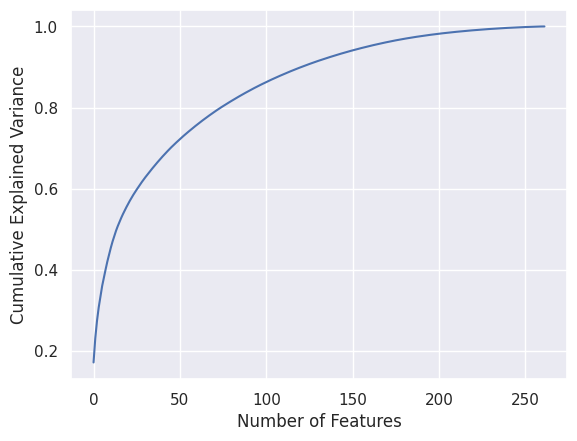

<Figure size 640x480 with 0 Axes>

In [25]:
with open("Data/MoS2_Analysis_Data_layer4", "rb") as fp:   # Unpickling layer3, avgpool
    MoS2_Proj1_Class_Data = pickle.load(fp)

#features = MoS2_ImageNet_100_data[0]
df = pd.DataFrame(MoS2_Proj1_Class_Data)


features = np.array(list(df['ImageNet']))


from sklearn.decomposition import PCA
import matplotlib as mpl 

mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

import seaborn as sns; sns.set()

pca = PCA().fit(features)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance')
plt.show()
plt.clf()

In [74]:
print(type(round(0.6723, 2)))
print(cumvariance[0])

<class 'float'>
0.17809293


In [28]:
# 85% and 99% cumulative variance used
cumvariance = np.cumsum(pca.explained_variance_ratio_)#{4:[94, 219], 3:[156, 248], 2: [190, 253], avg: [28,142]}
#print(cumvariance.shape)
#print(cumvariance)
for index, item in enumerate(cumvariance):#>0.84 and round(item, 2)< 0.86:
    #print(item)
    if item == 0.85 or item >0.85:# and round(item, 2)< 0.86:
        print('index: ', index, 'item: ', item)
        break

index:  94 item:  0.85016936


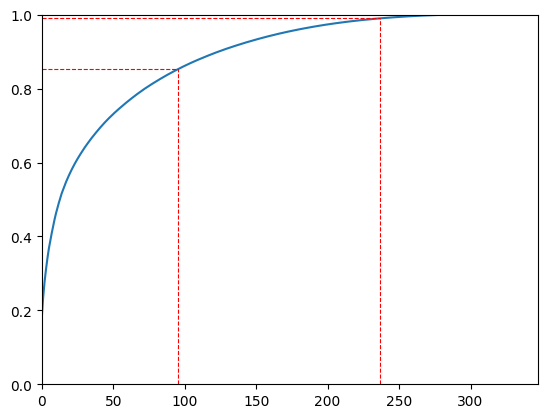

In [99]:
comp1 = 0.8519625
comp2 = 0.99

mpl.rcParams.update(mpl.rcParamsDefault)
#import seaborn as sns; sns.set()
fig, ax = plt.subplots()
ax.plot(cumvariance4)
#plt.xlabel('Number of Features')
#plt.ylabel('Cumulative Explained Variance')

ax.vlines(x=95, ymin=0, ymax=cumvariance4[95], color='red', zorder=2, linestyle='dashed', linewidth=0.8)
ax.hlines(y=cumvariance4[95], xmin=0, xmax=95, color='red', zorder=2, linestyle='dashed', linewidth=0.8)

ax.vlines(x=237, ymin=0, ymax=cumvariance4[237], color='red', zorder=2, linestyle='dashed', linewidth=0.8)
ax.hlines(y=cumvariance4[237], xmin=0, xmax=237, color='red', zorder=2, linestyle='dashed', linewidth=0.8)
plt.ylim(0, cumvariance4[-1])
plt.xlim(0, len(cumvariance4))
plt.show()
#plt.clf()